In [1]:
import pandas as pd
import polars as pl
import numpy as np
from time import time
import matplotlib.pyplot as plt
import seaborn as sns
import os
import gc
from  datetime import date
from pathlib import Path
import pyarrow.parquet as pq
from glob import glob
from copy import deepcopy 
ROOT = Path('C:/Users/Marcel/Documents/Python/kaggle/CreditRiskModel/data/parquet_files')


In [2]:
train_base = pd.read_parquet('C:/Users/Marcel/Documents/Python/kaggle/CreditRiskModel/data/parquet_files/train/train_base.parquet')
test_base = pd.read_parquet('C:/Users/Marcel/Documents/Python/kaggle/CreditRiskModel/data/parquet_files/test/test_base.parquet')

In [3]:
train_base['date_decision'] = pd.to_datetime(train_base['date_decision'])
test_base['date_decision'] = pd.to_datetime(test_base['date_decision'])


In [4]:
import yaml
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from colorama import Style, Fore

RC = {
    # "axes.facecolor": "#F8F8F8",
    # "figure.facecolor": "#F8F8F8",

    "axes.facecolor": "#FFF9ED",
    "figure.facecolor": "#FFF9ED",
    "axes.edgecolor": "#000000",
    "grid.color": "#EBEBE7" + "30",
    "font.family": "serif",
    "axes.labelcolor": "#000000",
    "xtick.color": "#000000",
    "ytick.color": "#000000",
    "grid.alpha": 0.4
}

PALETTE = ['#302c36', '#037d97', '#91013E', '#C09741',
           '#EC5B6D', '#90A6B1', '#6ca957', '#D8E3E2']


class ColorStyle(object):
    red = Style.BRIGHT + Fore.RED
    black = Style.BRIGHT + Fore.BLACK
    gold = Style.BRIGHT + Fore.YELLOW
    magenta = Style.BRIGHT + Fore.MAGENTA
    blue = Style.BRIGHT + Fore.BLUE
    white = Style.BRIGHT + Fore.WHITE
    res = Style.RESET_ALL


cS = ColorStyle()


def read_cfg(fp: str):
    """Reads configuration file"""
    with open(fp) as f:
        cfg = yaml.safe_load(f)
    return cfg


def plot_count(df: pd.DataFrame, col_list: list, title_name: str = 'Train') -> None:
    """Draws the pie and count plots for categorical variables.

    Args:
        df: train or test dataframes
        col_list: a list of the selected categorical variables.
        title_name: 'Train' or 'Test' (default 'Train')

    Returns:
        subplots of size (len(col_list), 2)
    """
    f, ax = plt.subplots(len(col_list), 2, figsize=(10, 4))
    plt.subplots_adjust(wspace=0)

    s1 = df[col_list].value_counts()
    N = len(s1)

    outer_sizes = s1
    inner_sizes = s1 / N

    outer_colors = ['#302c36']
    inner_colors = ['#EC0010']

    ax[0].pie(
        outer_sizes, colors=outer_colors,
        labels=s1.index.tolist(),
        startangle=0, frame=True, radius=1.3,
        explode=([0.05] * (N - 1) + [.3]),
        wedgeprops={'linewidth': 1, 'edgecolor': 'white'},
        textprops={'fontsize': 12, 'weight': 'bold'}
    )

    text_props = {
        'size': 13,
        'weight': 'bold',
        'color': 'white'
    }

    ax[0].pie(
        inner_sizes, colors=inner_colors,
        radius=1, startangle=0,
        autopct='%1.f%%', explode=([.1] * (N - 1) + [.3]),
        pctdistance=0.8, textprops=text_props
    )

    center_circle = plt.Circle((0, 0), .68, color='black',
                               fc='#FFF9ED', linewidth=0)
    ax[0].add_artist(center_circle)

    x = s1
    y = [0, 1]
    sns.barplot(
        x=x, y=y, ax=ax[1],
        palette=[PALETTE[0], '#EC0010'],
        orient='horizontal'
    )

    ax[1].spines['top'].set_visible(False)
    ax[1].spines['right'].set_visible(False)
    ax[1].tick_params(
        axis='x',
        which='both',
        bottom=False,
        labelbottom=False
    )

    for i, v in enumerate(s1):
        ax[1].text(v, i + 0.1, str(v), color='black',
                   fontweight='bold', fontsize=12)

    plt.setp(ax[1].get_yticklabels(), fontweight="bold")
    plt.setp(ax[1].get_xticklabels(), fontweight="bold")
    ax[1].set_xlabel(col_list, fontweight="bold", color='black')
    ax[1].set_ylabel('count', fontweight="bold", color='black')

    f.suptitle(f'{title_name} Dataset', fontsize=20, fontweight='bold')
    plt.tight_layout()
    plt.show()

In [5]:
# create full data paths for train / test data 
def adjust_data_path(data_storage, test = False):
    data_path = ROOT / 'train'
    file_prefix = 'train'
    if test:
        data_path = ROOT / 'test'
        file_prefix  = 'test'

    for depth, values in data_storage.items():
        for idx,val in enumerate(values):
            data_storage[depth][idx] = data_path / (file_prefix + val)
            
    return data_storage

def files_size(regex_paths ):
    # Getting real size of dataframe is hard therefore I will just estimate. I assume that every value is float 64 therefor every cell is 8 bytes. 
    size = pd.DataFrame(columns=['File name','Number of Rows','Number of Columns'])
    index = 0
    for depth, paths in regex_paths.items():
        for path in paths:
            files_paths = glob(str(path))
            for file in files_paths:
                size.loc[index,'File name']= file.rsplit('\\',1)[1].split('.',1)[0].split('_',1)[1]
                f =  pq.ParquetFile(file)
                size.loc[index,'Number of Rows'] = "{:.2f} k".format(f.metadata.num_rows / 1000)
                size.loc[index,'Number of Columns'] = f.metadata.num_columns
                size.loc[index,'Size'] = f.metadata.num_columns * f.metadata.num_rows * 8 // 1024** 2
                index +=1
    size = size.sort_values(by= 'Size', ascending=False)
    
    file_size = size['Size'].apply(lambda x: "{0} MB".format(x))
    size.drop(['Size'],axis = 1, inplace=True)
    size.loc[:,'Size (estimation)'] = file_size
    return size


In [6]:
data_storage = {
    'base':[
        '_base*'
        ],
    'depth0':[
        '_static_0*',
        '_static_cb_*'
        ],
    'depth1':[
        '_applprev_1*',
        '_other_1*',
        '_tax_registry_a*',
        '_tax_registry_b*',
        '_tax_registry_c*',
        '_credit_bureau_a_1*',
        '_credit_bureau_b_1*',
        '_deposit_1*',
        '_person_1*',
        '_debitcard_1*'
        ],
    'depth2':[
        '_applprev_2*',
        '_person_2*',
        '_credit_bureau_a_2*',
        '_credit_bureau_b_2*'
    ]
}

In [7]:
def data_info(df):
    print(f'{cS.red}[INFO] {cS.white}Decision date range in train data: {cS.red}{(df['date_decision'].max()- df['date_decision'].min()).days + 1} days')
    print(f'{cS.red}[INFO] {cS.white}Number of unique dates: {cS.red}{(df['date_decision'].nunique())} days')

    print(f'{cS.red}[INFO] {cS.white}Start Date: {cS.red}{df['date_decision'].min().date()} ')
    print(f'{cS.red}[INFO] {cS.white}End Date: {cS.red}{df['date_decision'].max().date()} ')



data_info(train_base)
print(f'{cS.red}/n-----------------TEST DATA-----------------/n')
data_info(test_base)

[INFO] Decision date range in train data: 644 days
[INFO] Number of unique dates: 644 days
[INFO] Start Date: 2019-01-01 
[INFO] End Date: 2020-10-05 
/n-----------------TEST DATA-----------------/n
[INFO] Decision date range in train data: 555 days
[INFO] Number of unique dates: 9 days
[INFO] Start Date: 2020-11-27 
[INFO] End Date: 2022-06-04 


In [10]:
train_storage = adjust_data_path(deepcopy(data_storage))
test_storage = adjust_data_path(deepcopy(data_storage), test=True)
train_files_sizes = files_size(train_storage)
test_files_sizes = files_size(test_storage)

train_files_sizes = train_files_sizes.set_index('File name').join(test_files_sizes.set_index('File name'), how = 'left', rsuffix='_TEST')
train_files_sizes.drop('Number of Columns_TEST',axis=1, inplace= True)
train_files_sizes


,Number of Rows,Number of Columns,Size (estimation),Number of Rows_TEST,Size (estimation)_TEST
File name,,,,,
credit_bureau_a_2_5,33053.76 k,19,4791.0 MB,0.01 k,0.0 MB
credit_bureau_a_2_4,27025.74 k,19,3917.0 MB,0.01 k,0.0 MB
credit_bureau_a_2_3,26563.90 k,19,3850.0 MB,0.01 k,0.0 MB
credit_bureau_a_2_6,25511.33 k,19,3698.0 MB,0.01 k,0.0 MB
credit_bureau_a_1_1,6009.19 k,79,3621.0 MB,0.01 k,0.0 MB
credit_bureau_a_2_9,18723.23 k,19,2714.0 MB,0.01 k,0.0 MB
credit_bureau_a_2_2,17893.54 k,19,2593.0 MB,0.01 k,0.0 MB
credit_bureau_a_1_0,4108.21 k,79,2476.0 MB,0.01 k,0.0 MB
credit_bureau_a_1_2,3743.81 k,79,2256.0 MB,0.01 k,0.0 MB


In [107]:
RC = {
    # "axes.facecolor": "#F8F8F8",
    # "figure.facecolor": "#F8F8F8",

    "axes.facecolor": "#FFF9ED",
    "figure.facecolor": "#FFF9ED",
    "axes.edgecolor": "#000000",
    "grid.color": "#EBEBE7" ,
    "font.family": "serif",
    "axes.labelcolor": "#000000",
    "xtick.color": "#000000",
    "ytick.color": "#000000",
    "grid.alpha": 0.4
}
sns.set_theme(rc=RC)
def count_plot_target(df, columns, index_names):
    fig, ax = plt.subplots(len(columns), 2, figsize=(14, 4*len(columns)))

    class_count = df[columns].value_counts()
    class_count.index = index_names
    outer_size =  class_count
    inner_size =  class_count / len(class_count)

    outer_colors = ['#302c36']
    inner_colors = ['#EC0010']

    ax[0].pie(
        outer_size, colors = outer_colors,
        labels = class_count.index.to_list(),
        startangle=0,frame=True,radius=1.3,
        explode=([0.05] * (len(class_count) - 1) + [.3]),
        wedgeprops= dict(width = 0.4, linewidth = 1, edgecolor= 'white'),
        textprops={'fontsize': 12, 'weight': 'bold'}
    )

    ax[0].pie(
        inner_size, colors = inner_colors,
        radius=1,startangle = 0,
        autopct = '%1.f%%',
        explode=([.1] * (len(class_count) - 1) + [.3]),
        wedgeprops = dict(width = 0.4),
        pctdistance=0.8, textprops = dict(color= 'white', weight = 'bold')
    )

    sns.barplot(
        x=class_count, y = class_count.index, ax = ax[1],
        palette= [outer_colors[0], inner_colors[0]],
        orient= 'horizontal', legend= False, hue = class_count.index,
    )
    ax[1].spines['top'].set_visible(False)
    ax[1].spines['right'].set_visible(False)
    ax[1].tick_params(
        axis='x',
        which='both',
        bottom=False,
        labelbottom=False
    )
    for i, v in enumerate(class_count):
        ax[1].text(v, i +  0.05 , str(v), color='black',
                   fontweight='bold', fontsize=12)
    plt.xticks(visible = False)
    plt.yticks(visible = False)
    ax[1].set_xlabel(columns, fontweight="bold", color='black')
    ax[1].set_ylabel('', fontweight="bold", color='black')
    fig.suptitle(f'Dataset class distribution', fontsize=20, fontweight='bold')
    plt.show()

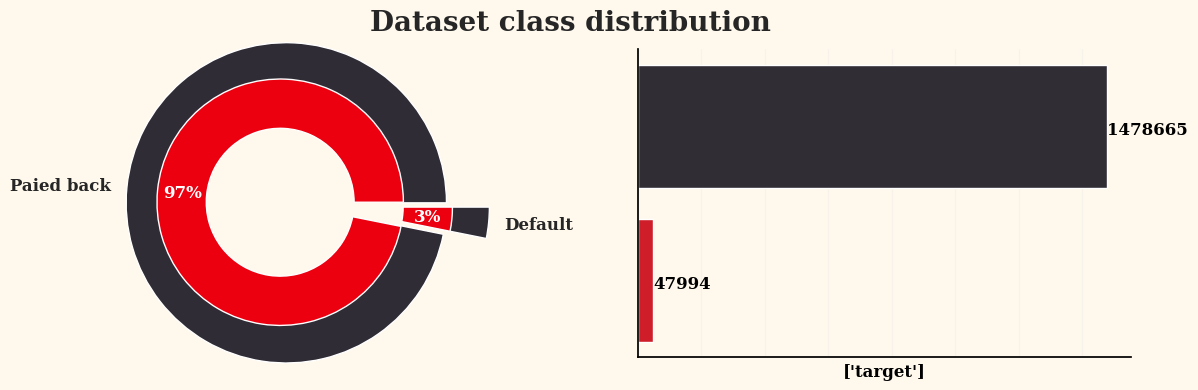

In [108]:
count_plot_target(train_base, ['target'], ['Paied back', 'Default'])